## Module 做了哪些事情

看到之前的例子中，我们做了很多事情，创建executor, 初始化参数，创建optimzer， 执行forward, backward, 打印训练结果和测试结果等等
这些步骤可以module里封装；


In [1]:
import sys
sys.path.insert(0, '/data00/hexi/apache-mxnet-src-1.1.0-incubating/python')
import mxnet as mx
import logging
logging.basicConfig(level=logging.DEBUG)

/data00/hexi/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_classes = 2
train_rec_path = "data/cats_vs_dogs/cats_vs_dogs_all_train.rec"
test_rec_path = "data/cats_vs_dogs/cats_vs_dogs_all_test.rec"
crop_size = (3, 224, 224)
batch_size = 256
num_epoch = 20

In [3]:
def residual_unit(data, num_filter, stride, dim_match, name, bottle_neck=True, bn_mom=0.9, workspace=256, memonger=False):
    """Return ResNet Unit symbol for building ResNet
    Parameters
    ----------
    data : str
        Input data
    num_filter : int
        Number of output channels
    bnf : int
        Bottle neck channels factor with regard to num_filter
    stride : tuple
        Stride used in convolution
    dim_match : Boolean
        True means channel number between input and output is the same, otherwise means differ
    name : str
        Base name of the operators
    workspace : int
        Workspace used in convolution operator
    """
    if bottle_neck:
        # the same as https://github.com/facebook/fb.resnet.torch#notes, a bit difference with origin paper
        bn1 = mx.sym.BatchNorm(data=data, fix_gamma=False, eps=2e-5, momentum=bn_mom, name=name + '_bn1')
        act1 = mx.sym.Activation(data=bn1, act_type='relu', name=name + '_relu1')
        conv1 = mx.sym.Convolution(data=act1, num_filter=int(num_filter*0.25), kernel=(1,1), stride=(1,1), pad=(0,0),
                                   no_bias=True, workspace=workspace, name=name + '_conv1')
        bn2 = mx.sym.BatchNorm(data=conv1, fix_gamma=False, eps=2e-5, momentum=bn_mom, name=name + '_bn2')
        act2 = mx.sym.Activation(data=bn2, act_type='relu', name=name + '_relu2')
        conv2 = mx.sym.Convolution(data=act2, num_filter=int(num_filter*0.25), kernel=(3,3), stride=stride, pad=(1,1),
                                   no_bias=True, workspace=workspace, name=name + '_conv2')
        bn3 = mx.sym.BatchNorm(data=conv2, fix_gamma=False, eps=2e-5, momentum=bn_mom, name=name + '_bn3')
        act3 = mx.sym.Activation(data=bn3, act_type='relu', name=name + '_relu3')
        conv3 = mx.sym.Convolution(data=act3, num_filter=num_filter, kernel=(1,1), stride=(1,1), pad=(0,0), no_bias=True,
                                   workspace=workspace, name=name + '_conv3')
        if dim_match:
            shortcut = data
        else:
            shortcut = mx.sym.Convolution(data=act1, num_filter=num_filter, kernel=(1,1), stride=stride, no_bias=True,
                                            workspace=workspace, name=name+'_sc')
        if memonger:
            shortcut._set_attr(mirror_stage='True')
        return conv3 + shortcut
    else:
        bn1 = mx.sym.BatchNorm(data=data, fix_gamma=False, momentum=bn_mom, eps=2e-5, name=name + '_bn1')
        act1 = mx.sym.Activation(data=bn1, act_type='relu', name=name + '_relu1')
        conv1 = mx.sym.Convolution(data=act1, num_filter=num_filter, kernel=(3,3), stride=stride, pad=(1,1),
                                      no_bias=True, workspace=workspace, name=name + '_conv1')
        bn2 = mx.sym.BatchNorm(data=conv1, fix_gamma=False, momentum=bn_mom, eps=2e-5, name=name + '_bn2')
        act2 = mx.sym.Activation(data=bn2, act_type='relu', name=name + '_relu2')
        conv2 = mx.sym.Convolution(data=act2, num_filter=num_filter, kernel=(3,3), stride=(1,1), pad=(1,1),
                                      no_bias=True, workspace=workspace, name=name + '_conv2')
        if dim_match:
            shortcut = data
        else:
            shortcut = mx.sym.Convolution(data=act1, num_filter=num_filter, kernel=(1,1), stride=stride, no_bias=True,
                                            workspace=workspace, name=name+'_sc')
        if memonger:
            shortcut._set_attr(mirror_stage='True')
        return conv2 + shortcut

def resnet(units, num_stages, filter_list, num_classes, image_shape, bottle_neck=True, bn_mom=0.9, workspace=256, dtype='float32', memonger=False):
    """Return ResNet symbol of
    Parameters
    ----------
    units : list
        Number of units in each stage
    num_stages : int
        Number of stage
    filter_list : list
        Channel size of each stage
    num_classes : int
        Ouput size of symbol
    dataset : str
        Dataset type, only cifar10 and imagenet supports
    workspace : int
        Workspace used in convolution operator
    dtype : str
        Precision (float32 or float16)
    """
    num_unit = len(units)
    assert(num_unit == num_stages)
    data = mx.sym.Variable(name='data')
    if dtype == 'float32':
        data = mx.sym.identity(data=data, name='id')
    else:
        if dtype == 'float16':
            data = mx.sym.Cast(data=data, dtype=np.float16)
    data = mx.sym.BatchNorm(data=data, fix_gamma=True, eps=2e-5, momentum=bn_mom, name='bn_data')
    (nchannel, height, width) = image_shape
    if height <= 32:            # such as cifar10
        body = mx.sym.Convolution(data=data, num_filter=filter_list[0], kernel=(3, 3), stride=(1,1), pad=(1, 1),
                                  no_bias=True, name="conv0", workspace=workspace)
    else:                       # often expected to be 224 such as imagenet
        body = mx.sym.Convolution(data=data, num_filter=filter_list[0], kernel=(7, 7), stride=(2,2), pad=(3, 3),
                                  no_bias=True, name="conv0", workspace=workspace)
        body = mx.sym.BatchNorm(data=body, fix_gamma=False, eps=2e-5, momentum=bn_mom, name='bn0')
        body = mx.sym.Activation(data=body, act_type='relu', name='relu0')
        body = mx.sym.Pooling(data=body, kernel=(3, 3), stride=(2,2), pad=(1,1), pool_type='max')

    for i in range(num_stages):
        body = residual_unit(body, filter_list[i+1], (1 if i==0 else 2, 1 if i==0 else 2), False,
                             name='stage%d_unit%d' % (i + 1, 1), bottle_neck=bottle_neck, workspace=workspace,
                             memonger=memonger)
        for j in range(units[i]-1):
            body = residual_unit(body, filter_list[i+1], (1,1), True, name='stage%d_unit%d' % (i + 1, j + 2),
                                 bottle_neck=bottle_neck, workspace=workspace, memonger=memonger)
    bn1 = mx.sym.BatchNorm(data=body, fix_gamma=False, eps=2e-5, momentum=bn_mom, name='bn1')
    relu1 = mx.sym.Activation(data=bn1, act_type='relu', name='relu1')
    # Although kernel is not used here when global_pool=True, we should put one
    pool1 = mx.sym.Pooling(data=relu1, global_pool=True, kernel=(7, 7), pool_type='avg', name='pool1')
    flat = mx.sym.Flatten(data=pool1)
    fc1 = mx.sym.FullyConnected(data=flat, num_hidden=num_classes, name='fc1')
    if dtype == 'float16':
        fc1 = mx.sym.Cast(data=fc1, dtype=np.float32)
    return mx.sym.SoftmaxOutput(data=fc1, name='softmax')

def get_symbol(num_classes, num_layers, image_shape, conv_workspace=256, dtype='float32', **kwargs):
    """
    Adapted from https://github.com/tornadomeet/ResNet/blob/master/train_resnet.py
    Original author Wei Wu
    """
    image_shape = [int(l) for l in image_shape.split(',')]
    (nchannel, height, width) = image_shape
    if height <= 28:
        num_stages = 3
        if (num_layers-2) % 9 == 0 and num_layers >= 164:
            per_unit = [(num_layers-2)//9]
            filter_list = [16, 64, 128, 256]
            bottle_neck = True
        elif (num_layers-2) % 6 == 0 and num_layers < 164:
            per_unit = [(num_layers-2)//6]
            filter_list = [16, 16, 32, 64]
            bottle_neck = False
        else:
            raise ValueError("no experiments done on num_layers {}, you can do it yourself".format(num_layers))
        units = per_unit * num_stages
    else:
        if num_layers >= 50:
            filter_list = [64, 256, 512, 1024, 2048]
            bottle_neck = True
        else:
            filter_list = [64, 64, 128, 256, 512]
            bottle_neck = False
        num_stages = 4
        if num_layers == 18:
            units = [2, 2, 2, 2]
        elif num_layers == 34:
            units = [3, 4, 6, 3]
        elif num_layers == 50:
            units = [3, 4, 6, 3]
        elif num_layers == 101:
            units = [3, 4, 23, 3]
        elif num_layers == 152:
            units = [3, 8, 36, 3]
        elif num_layers == 200:
            units = [3, 24, 36, 3]
        elif num_layers == 269:
            units = [3, 30, 48, 8]
        else:
            raise ValueError("no experiments done on num_layers {}, you can do it yourself".format(num_layers))

    return resnet(units       = units,
                  num_stages  = num_stages,
                  filter_list = filter_list,
                  num_classes = num_classes,
                  image_shape = image_shape,
                  bottle_neck = bottle_neck,
                  workspace   = conv_workspace,
                  dtype       = dtype)

def get_mlp_symbol(num_classes=10, **kwargs):
    data = mx.symbol.Variable('data')
    data = mx.sym.Flatten(data=data)
    fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
    act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
    fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
    act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
    fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=num_classes)
    mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')
    return mlp

In [4]:
def get_train_dataiter(rec_path, crop_size, batch_size, kv):
    dataiter = mx.io.ImageRecordIter(
        path_imgrec = rec_path,
        data_shape  = crop_size,
        data_name   = 'data',
        label_name  = 'softmax_label',
        label_width = 1,
        scale = 1.0/255,
        batch_size  = batch_size,
        resize = 250,
        rand_crop   = True,
        rand_mirror = True,
        shuffle = True,
        preprocess_threads = 6,
        num_parts   = kv.num_workers,
        part_index  = kv.rank
    )
    return dataiter

def get_test_dataiter(rec_path, crop_size, batch_size, kv):
    dataiter = mx.io.ImageRecordIter(
        path_imgrec = rec_path,
        data_shape  = crop_size,
        data_name   = 'data',
        label_name  = 'softmax_label',
        label_width = 1,
        scale = 1.0/255,
        batch_size  = batch_size,
        resize = 250,
        rand_crop   = False,
        rand_mirror = False,
        preprocess_threads = 6
    )
    return dataiter    
    

In [11]:
kvstore = mx.kv.create("cpu")
data_iter = get_train_dataiter(train_rec_path, crop_size, batch_size, kvstore)
val_iter = get_test_dataiter(test_rec_path, crop_size, batch_size, kvstore)
module = mx.mod.Module(get_symbol(num_classes=2, num_layers=18, image_shape="3,224,224"), data_names=('data',), label_names=('softmax_label',), context=[mx.gpu(0),mx.gpu(1)])
lr_decay = mx.lr_scheduler.FactorScheduler(
            step = 50,
            factor = 0.9)
optimizer = mx.optimizer.SGD(learning_rate = 0.01,
                            wd = 0.0005,
                            momentum = 0.9,
                            #lr_scheduler = lr_decay,
                            rescale_grad = 1.0/batch_size)
metric = mx.metric.Accuracy()
speed_callback = mx.callback.Speedometer(batch_size, 100)
save_checkpoint = mx.callback.do_checkpoint("./model", 4)
module.fit(data_iter,
           eval_data = val_iter,
           optimizer = optimizer,
           eval_metric = metric,
           num_epoch = num_epoch,
           batch_end_callback = speed_callback,
           epoch_end_callback = save_checkpoint,
           kvstore = kvstore)

INFO:root:Epoch[0] Train-accuracy=0.677809
INFO:root:Epoch[0] Time cost=172.218
INFO:root:Epoch[0] Validation-accuracy=0.659766
INFO:root:Epoch[1] Train-accuracy=0.760116
INFO:root:Epoch[1] Time cost=171.483
INFO:root:Epoch[1] Validation-accuracy=0.771484
INFO:root:Epoch[2] Train-accuracy=0.805188
INFO:root:Epoch[2] Time cost=171.400
INFO:root:Epoch[2] Validation-accuracy=0.806538
INFO:root:Epoch[3] Train-accuracy=0.839543
INFO:root:Epoch[3] Time cost=171.508
INFO:root:Saved checkpoint to "./model-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.823633
INFO:root:Epoch[4] Train-accuracy=0.855569
INFO:root:Epoch[4] Time cost=171.448
INFO:root:Epoch[4] Validation-accuracy=0.858553
INFO:root:Epoch[5] Train-accuracy=0.881861
INFO:root:Epoch[5] Time cost=171.520
INFO:root:Epoch[5] Validation-accuracy=0.827930
INFO:root:Epoch[6] Train-accuracy=0.897135
INFO:root:Epoch[6] Time cost=171.551
INFO:root:Epoch[6] Validation-accuracy=0.899054
INFO:root:Epoch[7] Train-accuracy=0.909806
INFO:root

In [5]:
sym,arg_params,aux_params = mx.model.load_checkpoint('model', 16)

In [6]:
mod = mx.mod.Module(symbol=sym,context=mx.gpu(0),data_names=['data'],label_names=['softmax_label'])

In [7]:
mod.bind(for_training=False,data_shapes=[('data',(1,3,224,224))])

/data00/hexi/apache-mxnet-src-1.1.0-incubating/python/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [8]:
mod.set_params(arg_params,aux_params)

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(path, show=False):
    # load image, rgb
    img = io.imread(path)
    print("Original Image Shape: ", img.shape)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # we crop image from center
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy : yy + short_egde, xx : xx + short_egde]
    # resize to 224, 224
    resized_img = transform.resize(crop_img, (224, 224))
    # convert to numpy.ndarray
    sample = np.asarray(resized_img) 
    # swap axes to make image from (224, 224, 3) to (3, 224, 224)
    sample = np.swapaxes(sample, 0, 2)
    sample = np.swapaxes(sample, 1, 2)
    sample = sample[np.newaxis, :]
    # sub mean
    return sample

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    print prob
    # print the top-5
    prob = np.squeeze(prob)
    prob = np.argsort(prob)[::-1]
    top1=prob[0]#取概率最高的一类
    print top1  #输入类别

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


('Original Image Shape: ', (499, 319, 3))
[[0.9913214  0.00867864]]
0


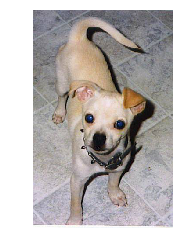

In [36]:
predict("data/cats_vs_dogs/train_data/dog.10040.jpg")